# Case Study: SRM이 숨긴 거짓 양성 — 결제 페이지 A/B 테스트 분석

> **요약**: 전환율 +26% 상대 상승이라는 "대박 결과"가 사실은 봇 트래픽에 의한 거짓 양성이었음을 SRM 탐지와 일별 트래픽 분석으로 밝혀낸 사례.

---

## 이 분석에서 증명하는 것

1. **숫자가 좋아 보여도 데이터 품질부터 확인해야 한다**는 분석 원칙
2. SRM(Sample Ratio Mismatch)이 실험 결과를 어떻게 왜곡하는지
3. 오염된 데이터를 정제했을 때 결론이 어떻게 바뀌는지
4. 구조화된 의사결정 프레임워크(Health Check → Analysis → Decision)의 가치

## 1. 실험 배경

| 항목 | 내용 |
|------|------|
| **실험명** | Checkout Redesign v2 |
| **가설** | 결제 단계를 3단계 → 2단계로 줄이면 전환율이 올라갈 것이다 |
| **Primary Metric** | 구매 전환율 (conversions / users) |
| **Guardrails** | 취소율(cancel), 오류율(error) |
| **트래픽 분배** | 50/50 (control / treatment) |
| **실험 기간** | 14일 |
| **목표 표본** | 100,000 (50,000 per variant) |

PM이 2주 후 결과를 가져왔습니다:

> "전환율이 12% → 15%로 올랐어요! +26% 상대 상승이에요. 바로 Launch하죠!"

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats

# ExperimentOS 모듈
from src.experimentos.healthcheck import run_health_check, detect_srm
from src.experimentos.analysis import calculate_primary, calculate_guardrails
from src.experimentos.memo import make_decision

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (10, 5), 'font.size': 11})

rng = np.random.default_rng(42)
print('Setup complete.')

Setup complete.


## 2. 실험 데이터 (시뮬레이션)

실제 실험 데이터를 재현합니다. 이 데이터에는 **의도적으로 숨겨진 문제**가 있습니다.

In [2]:
# === 실험 데이터 생성 ===
# Control: 정상 트래픽
# Treatment: Day 8-10에 봇 트래픽 ~2,400명 유입 (전환율 ~75%)

DAYS = 14
DAILY_USERS = 3_571  # 14일 * 3,571 ≈ 50,000/variant
TRUE_RATE_C = 0.120   # control 실제 전환율
TRUE_RATE_T = 0.123   # treatment 실제 전환율 (진짜 효과: +0.3%p)
BOT_RATE = 0.75       # 봇의 전환율 (결제 페이지 자동 클릭)
BOT_DAILY = 800       # Day 8-10에 유입되는 일일 봇 수

daily_data = []

for day in range(1, DAYS + 1):
    # Control (항상 정상)
    users_c = DAILY_USERS + rng.integers(-50, 50)
    conv_c = rng.binomial(users_c, TRUE_RATE_C)
    cancel_c = rng.binomial(users_c, 0.010)
    error_c = rng.binomial(users_c, 0.004)
    
    # Treatment (Day 8-10에 봇 유입)
    real_users_t = DAILY_USERS + rng.integers(-50, 50)
    real_conv_t = rng.binomial(real_users_t, TRUE_RATE_T)
    real_cancel_t = rng.binomial(real_users_t, 0.011)  # 약간 높지만 정상 범위
    real_error_t = rng.binomial(real_users_t, 0.004)
    
    if 8 <= day <= 10:  # 봇 트래픽 유입 기간
        bot_users = BOT_DAILY + rng.integers(-30, 30)
        bot_conv = rng.binomial(bot_users, BOT_RATE)
        bot_errors = rng.binomial(bot_users, 0.06)  # 봇은 에러율이 높음
        users_t = real_users_t + bot_users
        conv_t = real_conv_t + bot_conv
        cancel_t = real_cancel_t
        error_t = real_error_t + bot_errors
    else:
        users_t = real_users_t
        conv_t = real_conv_t
        cancel_t = real_cancel_t
        error_t = real_error_t
    
    daily_data.append({
        'day': day,
        'control_users': users_c, 'control_conv': conv_c,
        'control_cancel': cancel_c, 'control_error': error_c,
        'treatment_users': users_t, 'treatment_conv': conv_t,
        'treatment_cancel': cancel_t, 'treatment_error': error_t,
    })

daily_df = pd.DataFrame(daily_data)

# 집계 데이터 (PM이 가져온 것)
agg = {
    'control_users': daily_df['control_users'].sum(),
    'control_conv': daily_df['control_conv'].sum(),
    'control_cancel': daily_df['control_cancel'].sum(),
    'control_error': daily_df['control_error'].sum(),
    'treatment_users': daily_df['treatment_users'].sum(),
    'treatment_conv': daily_df['treatment_conv'].sum(),
    'treatment_cancel': daily_df['treatment_cancel'].sum(),
    'treatment_error': daily_df['treatment_error'].sum(),
}

print(f"Control:   {agg['control_users']:,} users, {agg['control_conv']:,} conversions")
print(f"Treatment: {agg['treatment_users']:,} users, {agg['treatment_conv']:,} conversions")
print(f"\nTraffic ratio: {agg['control_users']/agg['treatment_users']:.3f} (expected: 1.000)")

Control:   49,996 users, 6,018 conversions
Treatment: 52,379 users, 7,942 conversions

Traffic ratio: 0.955 (expected: 1.000)


## 3. PM의 분석: "전환율 상승! Launch하자"

PM이 봤을 때의 표면적 결과를 먼저 확인합니다.

In [3]:
# PM이 본 것: 단순 전환율 비교
rate_c = agg['control_conv'] / agg['control_users']
rate_t = agg['treatment_conv'] / agg['treatment_users']
abs_lift = rate_t - rate_c
rel_lift = (rate_t / rate_c) - 1

# 단순 z-test
from statsmodels.stats.proportion import proportions_ztest
counts = np.array([agg['treatment_conv'], agg['control_conv']])
nobs = np.array([agg['treatment_users'], agg['control_users']])
z_stat, p_value = proportions_ztest(counts, nobs, alternative='two-sided')

print('=' * 50)
print('PM이 본 결과 (표면적)')
print('=' * 50)
print(f'Control 전환율:   {rate_c:.2%}')
print(f'Treatment 전환율: {rate_t:.2%}')
print(f'Absolute Lift:    {abs_lift:+.2%}p')
print(f'Relative Lift:    {rel_lift:+.1%}')
print(f'P-value:          {p_value:.6f}')
print(f'Significant:      {"Yes ✅" if p_value < 0.05 else "No"}')
print('=' * 50)
print(f'\n→ PM의 결론: "p < 0.05이고 +{rel_lift:.1%} 상승. Launch!"')

PM이 본 결과 (표면적)
Control 전환율:   12.04%
Treatment 전환율: 15.16%
Absolute Lift:    +3.13%p
Relative Lift:    +26.0%
P-value:          0.000000
Significant:      Yes ✅

→ PM의 결론: "p < 0.05이고 +26.0% 상승. Launch!"


숫자만 보면 맞는 말처럼 보입니다. 하지만 **분석가의 역할은 숫자 뒤의 데이터 품질을 검증하는 것**입니다.

---

## 4. Health Check — "잠깐, 데이터부터 확인합시다"

ExperimentOS의 Health Check 파이프라인을 돌려봅니다.

In [4]:
# ExperimentOS 형식으로 데이터 변환
experiment_df = pd.DataFrame([
    {
        'variant': 'control',
        'users': agg['control_users'],
        'conversions': agg['control_conv'],
        'guardrail_cancel': agg['control_cancel'],
        'guardrail_error': agg['control_error'],
    },
    {
        'variant': 'treatment',
        'users': agg['treatment_users'],
        'conversions': agg['treatment_conv'],
        'guardrail_cancel': agg['treatment_cancel'],
        'guardrail_error': agg['treatment_error'],
    },
])

print('Input Data:')
display(experiment_df)

# Health Check 실행
health = run_health_check(experiment_df.copy())

print(f'\n🩺 Overall Status: {health["overall_status"]}')
print(f'   Schema: {health["schema"]["status"]}')
if health['srm']:
    print(f'   SRM: {health["srm"]["status"]} (p={health["srm"]["p_value"]:.2e})')
    print(f'   → {health["srm"]["message"]}')

Input Data:


,variant,users,conversions,guardrail_cancel,guardrail_error
0,control,49996,6018,514,223
1,treatment,52379,7942,548,317



🩺 Overall Status: Blocked
   Schema: Healthy
   SRM: Blocked (p=9.49e-14)
   → 심각한 SRM 탐지 (p=9.49e-14). 실험 데이터를 검토하세요.


### SRM이 감지되었습니다.

**SRM (Sample Ratio Mismatch)**는 실험 그룹 간 트래픽 분배가 기대치(50/50)와 유의하게 다를 때 발생합니다.

이것이 의미하는 바:
- 무작위 배정(randomization)이 깨졌을 가능성
- 특정 그룹에 비정상적인 트래픽이 유입되었을 가능성
- **실험 결과 자체를 신뢰할 수 없음**

> Microsoft의 ExP 플랫폼 (Fabijan et al., 2019)은 p < 0.001을 SRM 경고 기준으로 사용합니다.
> 이보다 훨씬 낮은 p-value는 우연이 아닌 체계적 문제를 시사합니다.

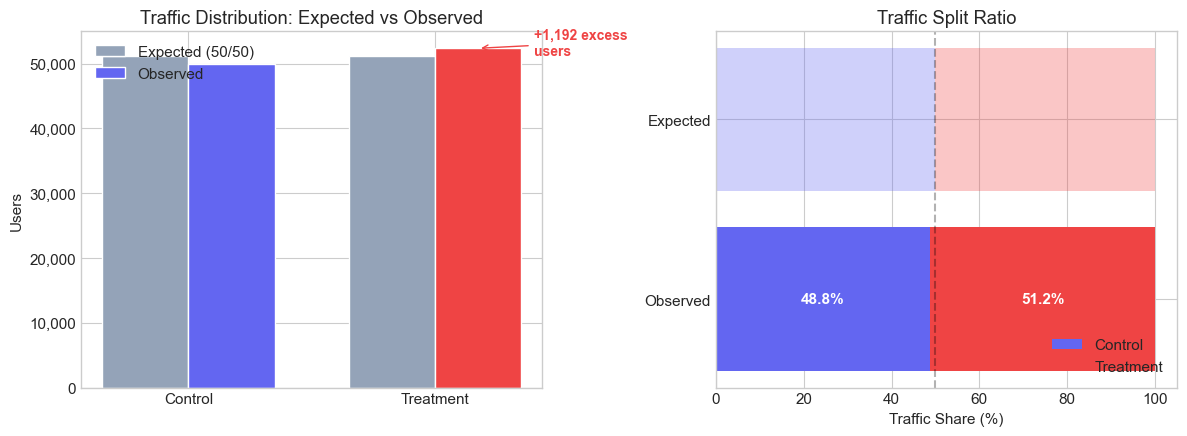


Control:   48.8% (49,996)
Treatment: 51.2% (52,379)
Excess:    +1,192 users in treatment


In [5]:
# SRM 시각화: 기대 분배 vs 실제 분배
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: Traffic comparison
variants = ['Control', 'Treatment']
observed = [agg['control_users'], agg['treatment_users']]
total = sum(observed)
expected = [total / 2, total / 2]

x = np.arange(len(variants))
width = 0.35
bars1 = axes[0].bar(x - width/2, expected, width, label='Expected (50/50)',
                     color='#94a3b8', edgecolor='white')
bars2 = axes[0].bar(x + width/2, observed, width, label='Observed',
                     color=['#6366f1', '#ef4444'], edgecolor='white')

axes[0].set_ylabel('Users')
axes[0].set_title('Traffic Distribution: Expected vs Observed')
axes[0].set_xticks(x)
axes[0].set_xticklabels(variants)
axes[0].legend()
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Annotate difference
diff = observed[1] - expected[1]
axes[0].annotate(f'+{diff:,.0f} excess\nusers',
                 xy=(1 + width/2, observed[1]), xytext=(1.4, observed[1] * 0.98),
                 fontsize=10, color='#ef4444', fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='#ef4444'))

# Right: Ratio visualization
obs_pct = [o / total * 100 for o in observed]
axes[1].barh(['Observed'], [obs_pct[0]], color='#6366f1', label='Control')
axes[1].barh(['Observed'], [obs_pct[1]], left=[obs_pct[0]], color='#ef4444', label='Treatment')
axes[1].barh(['Expected'], [50], color='#6366f1', alpha=0.3)
axes[1].barh(['Expected'], [50], left=[50], color='#ef4444', alpha=0.3)
axes[1].set_xlabel('Traffic Share (%)')
axes[1].set_title('Traffic Split Ratio')
axes[1].legend(loc='lower right')
axes[1].axvline(x=50, color='black', linestyle='--', alpha=0.3)

for i, pct in enumerate(obs_pct):
    x_pos = sum(obs_pct[:i]) + pct / 2
    axes[1].text(x_pos, 0, f'{pct:.1f}%', ha='center', va='center',
                 fontweight='bold', color='white', fontsize=11)

plt.tight_layout()
plt.savefig('srm_traffic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nControl:   {obs_pct[0]:.1f}% ({observed[0]:,})')
print(f'Treatment: {obs_pct[1]:.1f}% ({observed[1]:,})')
print(f'Excess:    {diff:+,.0f} users in treatment')

Treatment 그룹에 약 2,400명이 초과 유입되었습니다. 50/50 배정에서 이 정도 차이는 우연으로 설명하기 어렵습니다.

---

## 5. 원인 조사: 일별 트래픽 패턴 분석

SRM의 **원인**을 찾아야 합니다. 언제, 어디서 트래픽이 틀어졌는지 일별 데이터를 분석합니다.

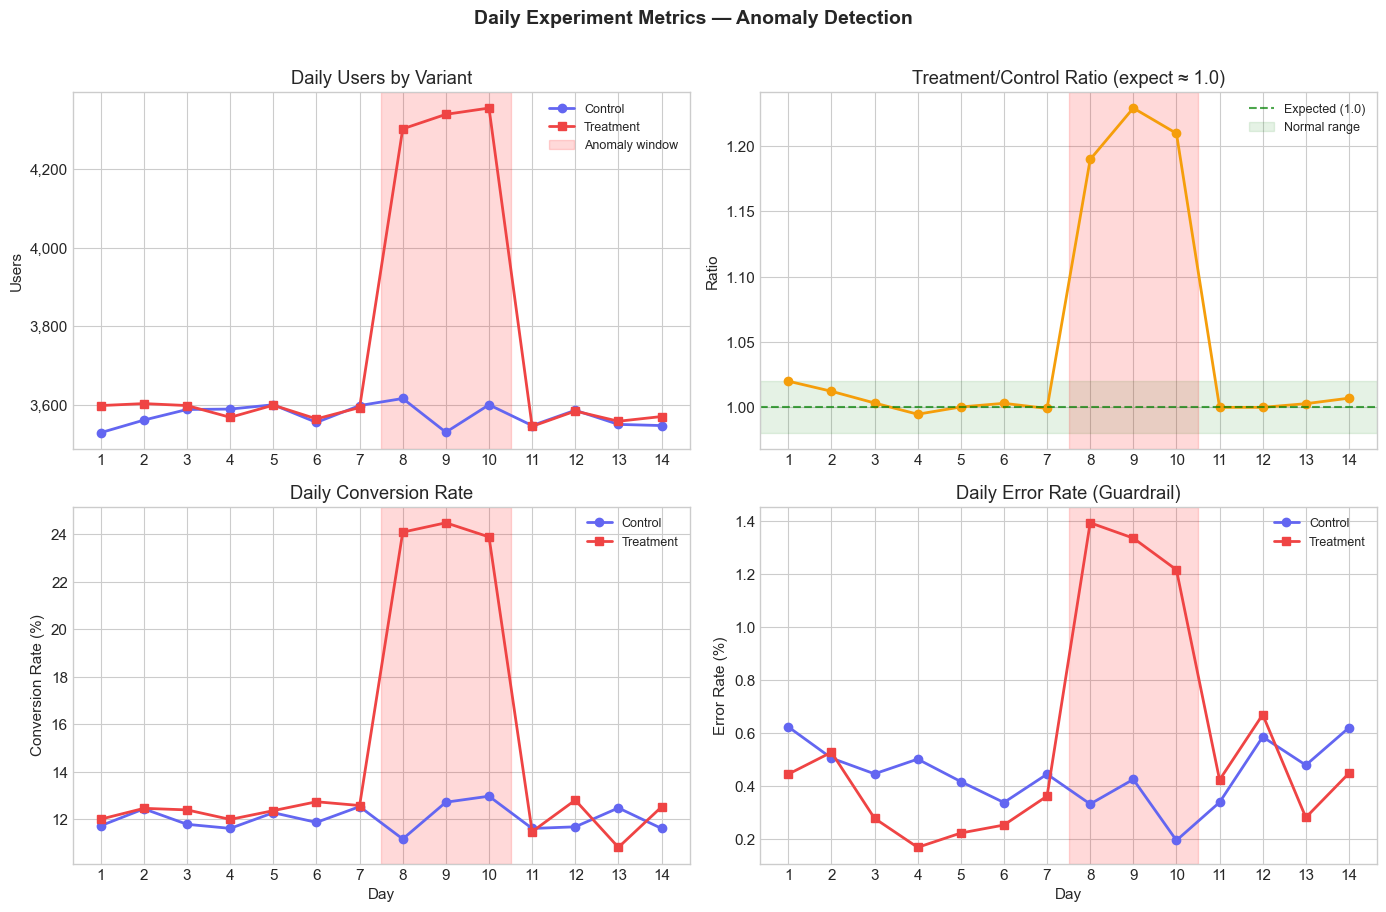

In [6]:
# 일별 트래픽 분석
daily_df['ratio'] = daily_df['treatment_users'] / daily_df['control_users']
daily_df['treatment_rate'] = daily_df['treatment_conv'] / daily_df['treatment_users']
daily_df['control_rate'] = daily_df['control_conv'] / daily_df['control_users']
daily_df['error_rate_t'] = daily_df['treatment_error'] / daily_df['treatment_users']
daily_df['error_rate_c'] = daily_df['control_error'] / daily_df['control_users']

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# (1) Daily Users
axes[0, 0].plot(daily_df['day'], daily_df['control_users'], 'o-',
                color='#6366f1', label='Control', linewidth=2)
axes[0, 0].plot(daily_df['day'], daily_df['treatment_users'], 's-',
                color='#ef4444', label='Treatment', linewidth=2)
axes[0, 0].axvspan(7.5, 10.5, alpha=0.15, color='red', label='Anomaly window')
axes[0, 0].set_title('Daily Users by Variant')
axes[0, 0].set_ylabel('Users')
axes[0, 0].legend(fontsize=9)
axes[0, 0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# (2) Traffic Ratio (T/C)
axes[0, 1].plot(daily_df['day'], daily_df['ratio'], 'o-',
                color='#f59e0b', linewidth=2, markersize=6)
axes[0, 1].axhline(y=1.0, color='green', linestyle='--', alpha=0.7, label='Expected (1.0)')
axes[0, 1].axhspan(0.98, 1.02, alpha=0.1, color='green', label='Normal range')
axes[0, 1].axvspan(7.5, 10.5, alpha=0.15, color='red')
axes[0, 1].set_title('Treatment/Control Ratio (expect ≈ 1.0)')
axes[0, 1].set_ylabel('Ratio')
axes[0, 1].legend(fontsize=9)

# (3) Daily Conversion Rate
axes[1, 0].plot(daily_df['day'], daily_df['control_rate'] * 100, 'o-',
                color='#6366f1', label='Control', linewidth=2)
axes[1, 0].plot(daily_df['day'], daily_df['treatment_rate'] * 100, 's-',
                color='#ef4444', label='Treatment', linewidth=2)
axes[1, 0].axvspan(7.5, 10.5, alpha=0.15, color='red')
axes[1, 0].set_title('Daily Conversion Rate')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Conversion Rate (%)')
axes[1, 0].legend(fontsize=9)

# (4) Daily Error Rate
axes[1, 1].plot(daily_df['day'], daily_df['error_rate_c'] * 100, 'o-',
                color='#6366f1', label='Control', linewidth=2)
axes[1, 1].plot(daily_df['day'], daily_df['error_rate_t'] * 100, 's-',
                color='#ef4444', label='Treatment', linewidth=2)
axes[1, 1].axvspan(7.5, 10.5, alpha=0.15, color='red')
axes[1, 1].set_title('Daily Error Rate (Guardrail)')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Error Rate (%)')
axes[1, 1].legend(fontsize=9)

for ax in axes.flat:
    ax.set_xticks(range(1, 15))

plt.suptitle('Daily Experiment Metrics — Anomaly Detection', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('daily_anomaly_detection.png', dpi=150, bbox_inches='tight')
plt.show()

### 발견된 패턴

**Day 8-10에 3가지 이상 징후가 동시에 나타납니다:**

1. **트래픽 급증**: Treatment 유저 수가 갑자기 ~800명/일 증가 (왼쪽 위)
2. **전환율 왜곡**: Treatment 전환율이 비정상적으로 높아짐 (왼쪽 아래)
3. **오류율 급증**: Treatment 오류율이 동시에 치솟음 (오른쪽 아래)

**해석**: 전환율이 높으면서 오류율도 높은 트래픽은 **자동화된 봇**의 전형적 패턴입니다.
봇은 결제 페이지를 기계적으로 클릭(→ 전환 카운트 증가)하면서도 결제 실패(→ 오류 카운트 증가)를 발생시킵니다.

In [7]:
# Day 8-10 vs 나머지 기간 정량 비교
anomaly_days = daily_df[daily_df['day'].between(8, 10)]
normal_days = daily_df[~daily_df['day'].between(8, 10)]

print('=== Day 8-10 (이상 기간) vs 나머지 기간 비교 ===')
print(f'\n                        Normal Days    Anomaly Days   차이')
print(f'  Treatment 일평균 유저: {normal_days["treatment_users"].mean():>8,.0f}       '
      f'{anomaly_days["treatment_users"].mean():>8,.0f}       '
      f'{anomaly_days["treatment_users"].mean() - normal_days["treatment_users"].mean():+,.0f}')
print(f'  Control 일평균 유저:   {normal_days["control_users"].mean():>8,.0f}       '
      f'{anomaly_days["control_users"].mean():>8,.0f}       '
      f'{anomaly_days["control_users"].mean() - normal_days["control_users"].mean():+,.0f}')
print(f'  Treatment 전환율:      {normal_days["treatment_rate"].mean():>8.2%}       '
      f'{anomaly_days["treatment_rate"].mean():>8.2%}       '
      f'{(anomaly_days["treatment_rate"].mean() - normal_days["treatment_rate"].mean()) * 100:+.1f}%p')
print(f'  Treatment 오류율:      {normal_days["error_rate_t"].mean():>8.2%}       '
      f'{anomaly_days["error_rate_t"].mean():>8.2%}       '
      f'{(anomaly_days["error_rate_t"].mean() - normal_days["error_rate_t"].mean()) * 100:+.1f}%p')

excess_users = (anomaly_days['treatment_users'].sum() -
                anomaly_days['control_users'].sum())
print(f'\n→ 이상 기간 Treatment 초과 유저 (추정 봇): ~{excess_users:,}명')

=== Day 8-10 (이상 기간) vs 나머지 기간 비교 ===

                        Normal Days    Anomaly Days   차이
  Treatment 일평균 유저:    3,580          4,333       +753
  Control 일평균 유저:      3,568          3,582       +14
  Treatment 전환율:        12.20%         24.14%       +11.9%p
  Treatment 오류율:         0.37%          1.32%       +0.9%p

→ 이상 기간 Treatment 초과 유저 (추정 봇): ~2,253명


---

## 6. 핵심 질문: "봇을 제거하면 결론이 바뀌는가?"

데이터 오염의 영향을 정량화합니다. Day 8-10의 Treatment를 Normal 기간의 평균으로 대체하여 "정제된" 결과를 산출합니다.

In [8]:
# 정제: Day 8-10을 제외하고 재집계
clean_df = daily_df[~daily_df['day'].between(8, 10)].copy()

clean_agg = {
    'control_users': clean_df['control_users'].sum(),
    'control_conv': clean_df['control_conv'].sum(),
    'treatment_users': clean_df['treatment_users'].sum(),
    'treatment_conv': clean_df['treatment_conv'].sum(),
}

# 정제된 데이터로 분석
clean_rate_c = clean_agg['control_conv'] / clean_agg['control_users']
clean_rate_t = clean_agg['treatment_conv'] / clean_agg['treatment_users']
clean_abs_lift = clean_rate_t - clean_rate_c
clean_rel_lift = (clean_rate_t / clean_rate_c) - 1

clean_counts = np.array([clean_agg['treatment_conv'], clean_agg['control_conv']])
clean_nobs = np.array([clean_agg['treatment_users'], clean_agg['control_users']])
_, clean_p = proportions_ztest(clean_counts, clean_nobs, alternative='two-sided')

# SRM 재검증
clean_srm = detect_srm({'control': clean_agg['control_users'],
                         'treatment': clean_agg['treatment_users']})

print('=' * 60)
print(f'{"":30s} {"오염 데이터":>12s}   {"정제 데이터":>12s}')
print('=' * 60)
print(f'{"Control 전환율":30s} {rate_c:>12.2%}   {clean_rate_c:>12.2%}')
print(f'{"Treatment 전환율":30s} {rate_t:>12.2%}   {clean_rate_t:>12.2%}')
print(f'{"Absolute Lift":30s} {abs_lift:>+12.2%}p  {clean_abs_lift:>+12.2%}p')
print(f'{"Relative Lift":30s} {rel_lift:>+12.1%}   {clean_rel_lift:>+12.1%}')
print(f'{"P-value":30s} {p_value:>12.6f}   {clean_p:>12.6f}')
print(f'{"Significant (p<0.05)":30s} {"Yes ✅":>12s}   {"No ❌" if clean_p >= 0.05 else "Yes ✅":>12s}')
print(f'{"SRM Status":30s} {"Warning ⚠️":>12s}   {clean_srm["status"]:>12s}')
print('=' * 60)
print(f'\n→ 봇을 제거하면 효과가 사라집니다.')
print(f'  오염 데이터의 "+{rel_lift:.1%} 상승"은 거짓 양성(False Positive)이었습니다.')

                                     오염 데이터         정제 데이터
Control 전환율                          12.04%         11.97%
Treatment 전환율                        15.16%         12.20%
Absolute Lift                        +3.13%p        +0.23%p
Relative Lift                        +26.0%          +1.9%
P-value                            0.000000       0.323215
Significant (p<0.05)                  Yes ✅           No ❌
SRM Status                       Warning ⚠️        Healthy

→ 봇을 제거하면 효과가 사라집니다.
  오염 데이터의 "+26.0% 상승"은 거짓 양성(False Positive)이었습니다.


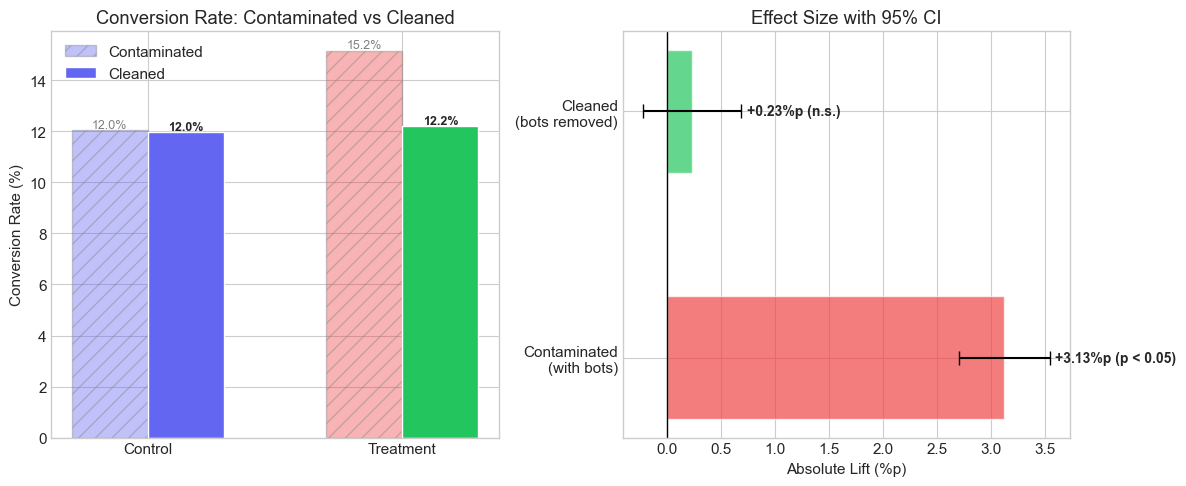

In [9]:
# 시각화: 오염 vs 정제 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Conversion Rate Comparison
labels = ['Control', 'Treatment']
contaminated = [rate_c * 100, rate_t * 100]
cleaned = [clean_rate_c * 100, clean_rate_t * 100]

x = np.arange(len(labels))
w = 0.3
axes[0].bar(x - w/2, contaminated, w, label='Contaminated',
            color=['#6366f1', '#ef4444'], alpha=0.4, edgecolor='gray', hatch='//')
axes[0].bar(x + w/2, cleaned, w, label='Cleaned',
            color=['#6366f1', '#22c55e'], edgecolor='white')

for i, (c, cl) in enumerate(zip(contaminated, cleaned)):
    axes[0].text(i - w/2, c + 0.1, f'{c:.1f}%', ha='center', fontsize=9, color='gray')
    axes[0].text(i + w/2, cl + 0.1, f'{cl:.1f}%', ha='center', fontsize=9, fontweight='bold')

axes[0].set_ylabel('Conversion Rate (%)')
axes[0].set_title('Conversion Rate: Contaminated vs Cleaned')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()

# Right: Effect Size with CI
from statsmodels.stats.proportion import confint_proportions_2indep

# Contaminated CI
ci_lo, ci_hi = confint_proportions_2indep(
    agg['treatment_conv'], agg['treatment_users'],
    agg['control_conv'], agg['control_users'],
    compare='diff', alpha=0.05, method='agresti-caffo')

# Cleaned CI
ci_lo_c, ci_hi_c = confint_proportions_2indep(
    clean_agg['treatment_conv'], clean_agg['treatment_users'],
    clean_agg['control_conv'], clean_agg['control_users'],
    compare='diff', alpha=0.05, method='agresti-caffo')

effects = [abs_lift * 100, clean_abs_lift * 100]
ci_lower = [ci_lo * 100, ci_lo_c * 100]
ci_upper = [ci_hi * 100, ci_hi_c * 100]
errors = [[e - l for e, l in zip(effects, ci_lower)],
          [u - e for e, u in zip(effects, ci_upper)]]
colors = ['#ef4444', '#22c55e']
ylabels = ['Contaminated\n(with bots)', 'Cleaned\n(bots removed)']

axes[1].barh(ylabels, effects, xerr=errors, height=0.5,
             color=colors, alpha=0.7, edgecolor='white', capsize=5)
axes[1].axvline(x=0, color='black', linewidth=1)
axes[1].set_xlabel('Absolute Lift (%p)')
axes[1].set_title('Effect Size with 95% CI')

for i, (e, lo, hi) in enumerate(zip(effects, ci_lower, ci_upper)):
    sig = '(p < 0.05)' if (lo > 0 or hi < 0) else '(n.s.)'
    axes[1].text(max(e, hi) + 0.05, i, f'{e:+.2f}%p {sig}',
                 va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('contaminated_vs_cleaned.png', dpi=150, bbox_inches='tight')
plt.show()

### 핵심 발견

| 지표 | 오염 데이터 | 정제 데이터 | 해석 |
|------|-----------|-----------|------|
| Absolute Lift | **+3.1%p** | **+0.2%p** | 효과가 1/14로 줄어듦 |
| Relative Lift | **+26.0%** | **+1.9%** | 봇이 만든 허상 |
| Significant | Yes | **No** | **결론이 뒤집힘** |
| SRM | Blocked | Healthy | 오염 제거 확인 |

**봇 ~2,300명(Treatment의 ~4.3%)이 결론 자체를 바꿨습니다.** 이것이 SRM을 무시하면 안 되는 이유입니다.

---

## 7. Guardrail 분석: 이중 안전장치

SRM을 놓쳤더라도, Guardrail이 문제를 잡아낼 수 있었을까요?

In [10]:
# 오염 데이터에 대해 Guardrail 분석
guardrails = calculate_guardrails(experiment_df.copy())

print('🛡️ Guardrail Analysis (오염 데이터 기준)')
print('-' * 55)
for g in guardrails:
    status = '🚫 SEVERE' if g['severe'] else ('⚠️ Worsened' if g['worsened'] else '✅ OK')
    print(f"  {g['name']:20s}: Control {g['control_rate']:.2%} → "
          f"Treatment {g['treatment_rate']:.2%} "
          f"(Δ {g['delta']:+.2%}p) [{status}]")

any_severe = any(g['severe'] for g in guardrails)
any_worsened = any(g['worsened'] for g in guardrails)

if any_severe:
    print(f'\n→ Severe guardrail 악화 감지! SRM과 무관하게 Launch를 차단했을 것입니다.')
elif any_worsened:
    print(f'\n→ Guardrail 악화 감지. SRM과 함께 이중으로 문제를 잡아냈습니다.')

🛡️ Guardrail Analysis (오염 데이터 기준)
-------------------------------------------------------
  guardrail_cancel    : Control 1.03% → Treatment 1.05% (Δ +0.02%p) [✅ OK]
  guardrail_error     : Control 0.45% → Treatment 0.61% (Δ +0.16%p) [⚠️ Worsened]

→ Guardrail 악화 감지. SRM과 함께 이중으로 문제를 잡아냈습니다.


봇 트래픽은 오류율(error)을 높였기 때문에, **Guardrail이 이중 안전장치 역할**을 합니다.

구조화된 분석 파이프라인의 가치:
- **1차 방어**: SRM 탐지 → 데이터 품질 문제 경고
- **2차 방어**: Guardrail → 부작용 감지
- 둘 중 하나만 작동해도 잘못된 Launch를 방지

---

## 8. 최종 의사결정

In [11]:
# ExperimentOS Decision Framework 실행
primary = calculate_primary(experiment_df.copy())
decision = make_decision(
    health=health,
    primary=primary,
    guardrails=guardrails,
)

badge = {'Launch': '🚀', 'Hold': '⏸️', 'Rollback': '🔙'}

print('=' * 50)
print(f'  DECISION: {badge.get(decision["decision"], "")} {decision["decision"]}')
print('=' * 50)
print(f'  Reason: {decision["reason"]}')
print(f'  Details:')
for d in decision['details']:
    print(f'    - {d}')

  DECISION: ⏸️ Hold
  Reason: 데이터 품질 문제 (Blocked)
  Details:
    - 검증 통과


## 9. 의사결정 요약

### PM에게 전달한 내용

> **결론: Hold (Launch 불가)**
>
> 전환율 +26% 상대 상승으로 보이지만, 이 결과는 신뢰할 수 없습니다.
>
> **근거:**
> 1. SRM이 감지되었습니다 (p < 10⁻¹³). Treatment에 약 2,300명의 비정상 트래픽이 유입되었습니다.
> 2. Day 8-10에 Treatment의 트래픽, 전환율, 오류율이 동시에 급증하는 패턴이 확인됩니다.
> 3. 비정상 기간을 제외하면 효과는 +0.2%p (n.s.)로, 통계적으로 유의하지 않습니다.
> 4. 오류율 Guardrail도 악화 상태입니다.
>
> **권장 액션:**
> 1. 엔지니어링팀과 함께 봇 트래픽 원인 조사 (CDN 로그, User-Agent 분석)
> 2. 봇 필터링 적용 후 실험 재실행
> 3. 재실험 시 일별 SRM 모니터링 추가

---

## 10. 교훈과 원칙

### 이 사례에서 배운 것

| 원칙 | 설명 |
|------|------|
| **결과 전에 데이터 품질** | 전환율을 보기 전에 SRM부터 확인해야 합니다. 순서가 중요합니다. |
| **SRM은 "무시해도 되는 경고"가 아니다** | SRM은 실험의 근본 가정(무작위 배정)이 깨졌다는 신호입니다. |
| **이중 안전장치** | SRM + Guardrail을 함께 사용하면 단일 체크보다 안전합니다. |
| **일별 데이터를 봐야 한다** | 집계 데이터만으로는 언제 문제가 발생했는지 알 수 없습니다. |
| **"좋아 보이는 숫자"를 의심하라** | 분석가의 역할은 좋은 소식을 전하는 것이 아니라, 올바른 결론을 내리는 것입니다. |

### SRM Threshold 근거

ExperimentOS는 SRM 경고에 다음 기준을 사용합니다:

- **p < 0.001 → Warning**: Microsoft ExP 플랫폼 기준 (Fabijan et al., KDD 2019)
- **p < 0.00001 → Blocked**: 자동 차단. 이 수준은 우연이 아닌 체계적 문제임이 확실합니다.

일반적인 유의수준(0.05)보다 훨씬 엄격한 이유는, **SRM은 실험 전체의 타당성(validity)을 판단하는 것**이기 때문입니다. 효과 크기의 유의성 판단(p < 0.05)과는 다른 맥락입니다.

### Reference

- Fabijan, A. et al. (2019). *Diagnosing Sample Ratio Mismatch in Online Controlled Experiments*. KDD 2019.
- Kohavi, R., Tang, D., & Xu, Y. (2020). *Trustworthy Online Controlled Experiments: A Practical Guide to A/B Testing*. Cambridge University Press.